## <center>Classification by Optimizing Profit</center>

 The steps involved in this process were,
 1. [Initial Setup](#init) - This step involves reading in the previously prepared data, train/test split and standardizing the features.
 2. [Exploratory Data Analysis](#expl) - In this step data was visualized using Kernel Density Estimate (KDE) plot and histograms to identify if there are any clear predictors of good and bad loans.
 3. [Establishing Baseline](#base) - This step involved setting up a custom profit function and establishing a baseline score to beat
 4. [Classification](#class) - Run various classifiers to find the best classifier which maximizes profit from a lenders perspective
 5. [Results](#result) - Final results.

In [140]:
import pandas as pd
import numpy as np
import time

#sklearn
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.externals import joblib

#classifiers
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree



#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
%matplotlib inline

<a id='init'></a>
### Initial Setup

In [3]:
df_processed = pd.read_csv('data/loan_fteng_data_text.csv')

In [4]:
df_processed.shape

(39301, 67)

#### Reading in processed data

In [5]:
#columns in dataset
df_processed.columns

Index(['loan_amnt', 'funded_amnt_inv', 'home_ownership', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'revol_bal', 'loan_status', 'desc_senti_score',
       'bill', 'card', 'consolid', 'credit', 'current', 'debt', 'fund', 'help',
       'interest', 'job', 'loan', 'money', 'month', 'pay', 'payment', 'plan',
       'rate', 'thank', 'time', 'work', 'year', 'zip_median_income', 'zip_pop',
       'per_act_open', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'term_ 36 months', 'term_ 60 months',
       'emp_length', 'int_rate', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vaca

In [6]:
#all features
all_features = list(df_processed.columns)

In [7]:
#text tfidf features
tfidf_features = ['bill', 'card', 'consolid', 'credit', 'current', 'debt', 'fund', 'help',
       'interest', 'job', 'loan', 'money', 'month', 'pay', 'payment', 'plan',
       'rate', 'thank', 'time', 'work', 'year']

#### Feature Engineering

In [8]:
#columns to be deleted - simlar to loan amount
del_columns = ['funded_amnt_inv'] + tfidf_features
#del_columns = ['funded_amnt_inv'] 

In [9]:
#Using intution to pick key predictors
predictors_intution = ['home_ownership','verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified','has_delinquent_hist','has_record_hist']

In [10]:
# % and whole numbers that can be standardized
predictors_standardizable = ['loan_amnt','per_act_open','inq_last_6mths','avg_fico','revol_util','revol_bal','dti','years_since_first_credit','int_rate','emp_length','desc_senti_score','zip_median_income', 'zip_pop']

In [11]:
predictors_remaining = [i for i in all_features if i not in predictors_intution and i not in predictors_standardizable and i not in del_columns]

In [12]:
#validating if all columns are there
test = predictors_intution + predictors_standardizable + predictors_remaining
len(test)

45

In [13]:
#full_data

full_df = df_processed.loc[:,test]

#### Train/Test set 

In [14]:
#Creating train/test data
itrain, itest = train_test_split(np.arange(full_df.shape[0]), train_size=0.7)

In [15]:
#creating a mask to identify train/test records across different types of feature selection later.
mask=np.ones(full_df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [16]:
mask

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

#### Standardizing Features

In [17]:

for col in predictors_standardizable:
    print(col)
    valstrain=full_df.loc[mask,col]
    valstest=full_df.loc[~mask,col]
    scaler=StandardScaler().fit(valstrain.reshape(-1,1))
    outtrain=scaler.transform(valstrain.reshape(-1,1))
    outtest=scaler.fit_transform(valstest.reshape(-1,1))
    out=np.empty(mask.shape[0])
    out.flat[mask]=outtrain
    out.flat[~mask]=outtest
    full_df[col]=out


loan_amnt
per_act_open
inq_last_6mths
avg_fico
revol_util
revol_bal
dti
years_since_first_credit
int_rate
emp_length
desc_senti_score
zip_median_income
zip_pop


/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [18]:
full_df.head(2)

home_ownership  verification_status_Not Verified  \
0               0                                 0   
1               0                                 1   

   verification_status_Source Verified  verification_status_Verified  \
0                                    0                             1   
1                                    0                             0   

   has_delinquent_hist  has_record_hist  loan_amnt  per_act_open  \
0                    0                0  -0.831975     -0.740633   
1                    0                0  -0.697002      2.067839   

   inq_last_6mths  avg_fico      ...       purpose_house  \
0        0.117313  0.555672      ...                   0   
1        0.117313 -0.704069      ...                   0   

   purpose_major_purchase  purpose_medical  purpose_moving  purpose_other  \
0                       0                0               0              0   
1                       0                0               0              0   

   purpose_renewable_energy  purpose_small_business  purpose_vacation  \
0                         0                       0                 0   
1                         0                       0                 0   

   purpose_wedding  bankruptcies  
0                0           0.0  
1                0           0.0  

[2 rows x 45 columns]

In [19]:
predictor_columns = list(full_df.columns)
predictor_columns.remove('loan_status')
len(predictor_columns)

44


<a id='expl'></a>
### Exploratory Data Analysis


In [20]:
#KDE plot for exploring continuous variables and histogram for indicators - discrete variables
print(len(predictors_standardizable))

indicators = [col for col in predictor_columns if col not in predictors_standardizable and col not in tfidf_features]
len(indicators)

13


31

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


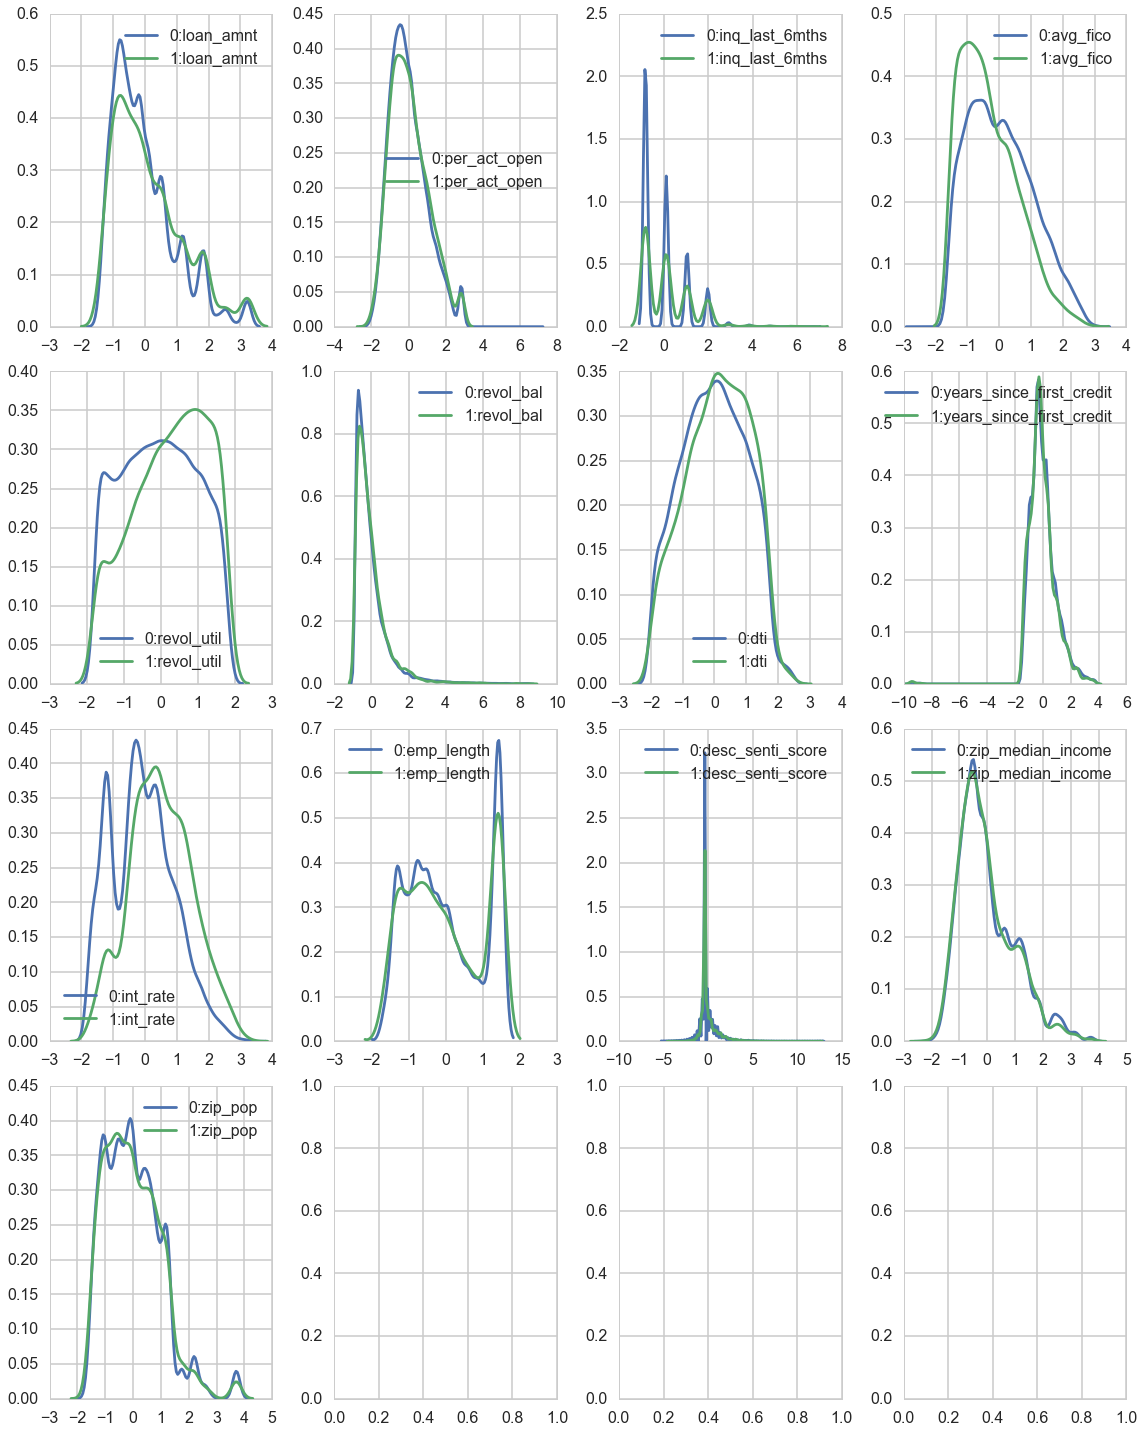

In [21]:
##### Kernel density estimate
#looking for features where the two line do not overlap much
df_grpby=full_df.groupby('loan_status')
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 20), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), predictors_standardizable):
    for k, v in df_grpby[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)

<b> Unfortuantely the standardized features all of them seam to overlap, none of them seem to be clear predictor<b>

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


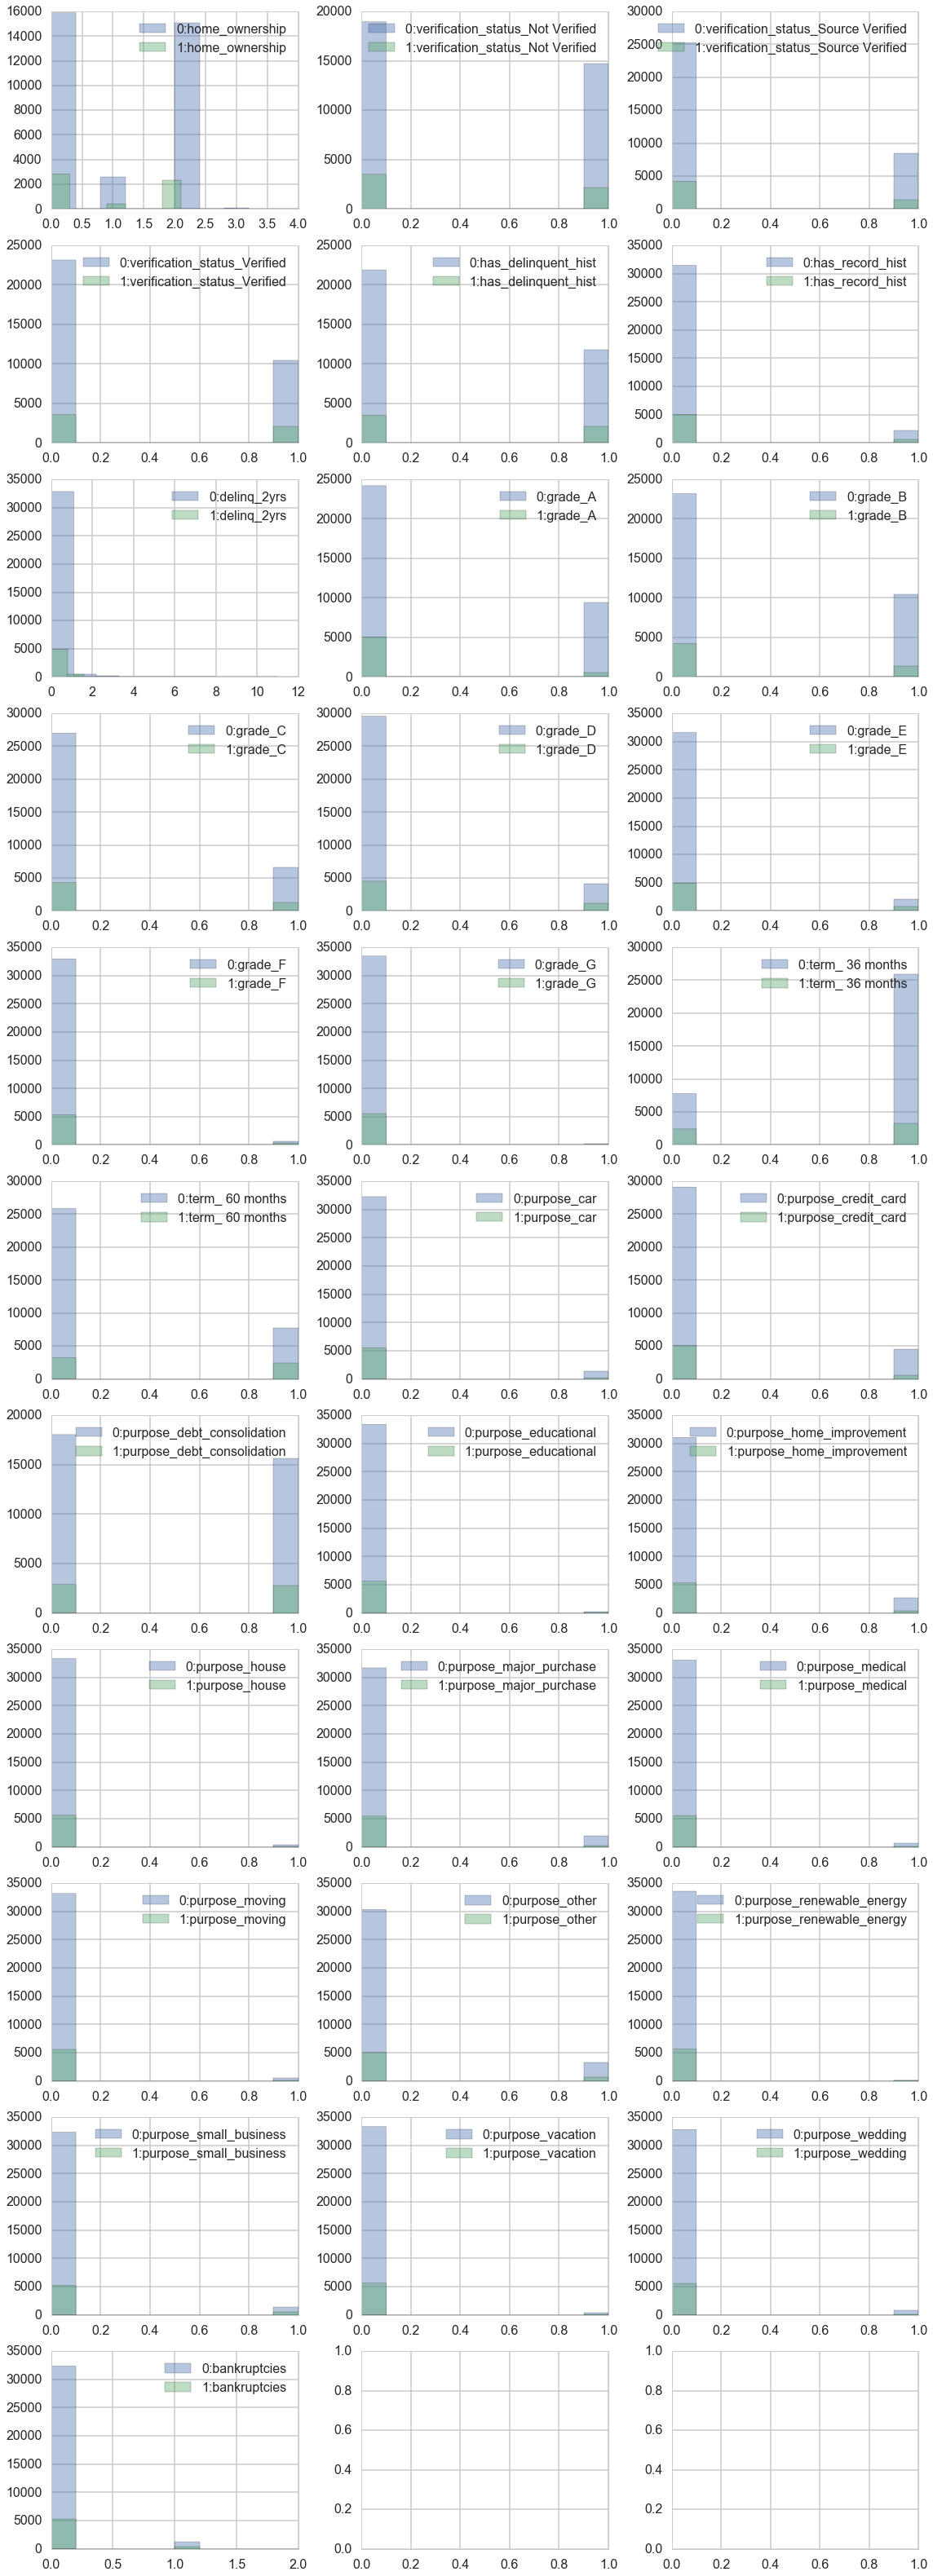

In [22]:
#histogram for indicator / discrete variables
#looking for bar which are exclusively belonging to one class
#your code here
df_grpby=full_df.groupby('loan_status')
fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(16, 44), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), indicators):
    for k, v in df_grpby[p]:
        v.hist(ax=ax, alpha=0.4, label=str(k)+":"+v.name)
        ax.legend()

<b>Homeownership and term of 36 months seem to be relatively strong predictors of bad loans<b>

<a id='base'></a>
### Establishing Baseline

#### Linear SVM

In [23]:
clf_svm=LinearSVC(loss="hinge")
C=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
X =full_df[predictor_columns]
Y =full_df['loan_status']

In [24]:
X_train=X[mask]
X_test=X[~mask]
Y_train=Y[mask]
Y_test=Y[~mask]

In [25]:

gs=GridSearchCV(clf_svm, param_grid={'C':C}, cv=5)
gs.fit(X_train, Y_train)
print("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_)

BEST {'C': 0.001} 0.856488549618 [mean: 0.85649, std: 0.00007, params: {'C': 0.001}, mean: 0.85649, std: 0.00007, params: {'C': 0.01}, mean: 0.85649, std: 0.00007, params: {'C': 0.1}, mean: 0.85649, std: 0.00007, params: {'C': 1.0}, mean: 0.85649, std: 0.00007, params: {'C': 10.0}, mean: 0.80632, std: 0.04069, params: {'C': 100.0}]


/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [26]:
#accuracy
best = gs.best_estimator_
best.fit(X_train, Y_train)
best.score(X_test, Y_test)

0.85548299550504625

In [27]:

'''

   Input
   -----
   X: Training Features
   Y_bin: Values Predicted binarized
   classifier_name: Name of classifier
   classifier: sklearn classifier init
   param_dict: dictionary of parameters to be passed to classifier
   scor_func: scoring method used
   no_cv: # of cvv
   
   Output
   ------
   training_time: training time in minutes
   best_estimator: best model after cvv
   best_params: best parameter 
   best_score: best score
   
'''

def perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None, reuse_split=None):
    #training start time
    start_time = time.clock()
    clf = classifier
    parameters = param_dict
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=no_cv, scoring=scor_func)
    
    if mask != None:
        X_train, X_test, y_train, y_test = X[mask], X[~mask], Y[mask], Y[~mask]
        
    if reuse_split !=None:
        print("using reuse split")
        X_train, X_test, y_train, y_test = reuse_split['X_train'], reuse_split['X_test'], reuse_split['Y_train'], reuse_split['Y_test']
    
    fitmodel.fit(X_train,y_train)
    

    
    best_estimator = fitmodel.best_estimator_
    best_params = fitmodel.best_params_
    best_score = fitmodel.best_score_
    
    end_time = time.clock()
    training_time = (end_time - start_time)/60.0
    
    training_accuracy = best_estimator.score(X_train, y_train)
    test_accuracy = best_estimator.score(X_test, y_test)
    print("-------------- based on standard predict -----------------")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(y_test, best_estimator.predict(X_test)))
    print("-----------------------------------------------------------")
    
    print('{} Training Time : {} minutes'.format(classifier_name,training_time))
    print('{} Best Estimator \n {}'.format(classifier_name,best_estimator))
    print('{} Best Params \n {}'.format(classifier_name,best_params))
    print('{} Best {} \n {}'.format(classifier_name,'accuracy',best_score))##, fitmodel.grid_scores_
    
    
    return training_time,best_estimator,best_params,best_score
  

In [28]:
#parameters passed for Linear SVM
classifier_name = 'Linear SVM'
classifier = LinearSVC(loss="hinge")
param_dict = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 5
scor_func = 'roc_auc'

In [29]:
#calling classifier on training set
lsvm_training_time,lsvm_best_estimator,lsvm_best_params,lsvm_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=mask,reuse_split=None)

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


-------------- based on standard predict -----------------
Accuracy on training data: 0.74
Accuracy on test data:     0.74
[[8067 2020]
 [1005  699]]
-----------------------------------------------------------
Linear SVM Training Time : 1.1659728666666669 minutes
Linear SVM Best Estimator 
 LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
Linear SVM Best Params 
 {'C': 100.0}
Linear SVM Best accuracy 
 0.5640855017443769


### Esimating Costs

In [30]:
##https://github.com/cs109-students/2015hw_solutions/blob/hw3/hw3_solutions.ipynb
np.sum(~mask)

11791

In [31]:
#checking symmetry of data
1-Y.mean()

0.8561868654741609

<b> Data is highly assymetric, just predicting all loans as good will give an accuracy of 86%. Also linear SVM is not better than just predicting all as good loans will also give an accuracy of ~86% <b>

In [32]:
1-Y.mean()

0.8561868654741609

#### Determining Costs associated with TN, FN, FP, TP

<img src='images/confusionmatrix.png'></img>

In [33]:
#
confusion_matrix(Y_test, lsvm_best_estimator.predict(X_test))

array([[8067, 2020],
       [1005,  699]])

<b>Our primary objective will be to maximize TP, therefore minizming FN. As FN would impact the lenders and they could potentially loose their investment</b>

#### True Negative

<b> TN (True Negative) are the good loans. The lenders only stand to gain from them. loss is 0 and gain corresponds to the interest  <b>

In [34]:
data_raw = pd.read_csv("data/loan_2007_2011.csv")

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
data_raw = data_raw.loc[data_raw.loan_status.isin(['Charged Off','Fully Paid']),:]

In [36]:
#computing true negative cost =  average interest gain per loan
tnc = -round(np.median(data_raw.total_rec_int),0)
tnc

-1333.0

In [37]:
#computing false negative score = minus of average interest gain per loan + lost interest 
fnc = round(np.sum(data_raw.funded_amnt_inv - data_raw.total_rec_prncp)/Y.sum(),0) + round(np.mean(data_raw.total_rec_int),0) 
fnc

6108.0

In [38]:
#computing true postive score = avg total principal that was lost + loss of interest
# no loss

tpc = 0

tpc

0

In [39]:
#computing false positive score, nothing gained, we will ignore interest loss
fpc = 0
fpc

0

In [40]:
#risk matrix
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
risk_matrix

array([[-1333.,     0.],
       [ 6108.,     0.]])

In [41]:
#profit matrix
u = -risk_matrix
u

array([[ 1333.,    -0.],
       [-6108.,    -0.]])

<b> Basically we are penalizing bad loans classified as good, which have a very bad effect on lenders <b>

In [42]:
#calculating average profit per loan
def average_profit_pl(y, ypred, u):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

#### Establishing base classifiers based on Profit matrix

In [43]:
#predicting all loans as good
testsize = full_df[~mask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print(confusion_matrix(Y_test, ypred_dste))
dsteval=average_profit_pl(Y_test, ypred_dste, u)
dsteval

[[10087     0]
 [ 1704     0]]


257.64896955304891

In [44]:
#predicting all as bad loans
ypred_ste = np.ones(testsize, dtype="int")
print(confusion_matrix(Y_test, ypred_ste))
steval = average_profit_pl(Y_test, ypred_ste, u)
steval

[[    0 10087]
 [    0  1704]]


0.0

<b> Thefore looks like predicting all loans as good is the one to beat<b>

In [45]:
profit_list = []
profit_dict = {'classifier':'Base Classifier:Predicting all loans = good','Profit Score': dsteval,'AUC': None,'Sensitivity':0}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

classifier  Profit Score   AUC  \
0  Base Classifier:Predicting all loans = good     257.64897  None   

   Sensitivity  
0            0

In [46]:
#now comparing against the linear svm result

In [47]:
average_profit_pl(Y_test, lsvm_best_estimator.predict(X_test), u)

391.38079891442624

In [48]:
def average_profit_func(clf,X,y):
    u=np.array([[ 1333.,    -0.],
       [-6108.,    -0.]])
    ypred = clf.predict(X)
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

<b>Linear SVM performs same as baseline<b>

<a id='class'></a>
### Classification

### Logistic Regression with Lasso Feature Selection

In [49]:
#parameters passed for Linear SVM
classifier_name = 'Logistic Regression with Lasso'
classifier = LogisticRegression(penalty="l1")
param_dict = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 5
scor_func = average_profit_func


In [50]:
#calling classifier on training set
logL_training_time,logL_best_estimator,logL_best_params,logL_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=mask,reuse_split=None)

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


-------------- based on standard predict -----------------
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[10070    17]
 [ 1686    18]]
-----------------------------------------------------------
Logistic Regression with Lasso Training Time : 1.4102281166666666 minutes
Logistic Regression with Lasso Best Estimator 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression with Lasso Best Params 
 {'C': 1.0}
Logistic Regression with Lasso Best accuracy 
 272.52624500181753


In [51]:
#profit 
profit_logl = average_profit_pl(Y_test, logL_best_estimator.predict(X_test), u)
profit_logl

265.05147994232891

In [52]:
fpr_logl, tpr_logl, thresholds_logl = roc_curve(Y_test, logL_best_estimator.predict_proba(X_test)[:,1])
auc_logl = auc(fpr_logl,tpr_logl)
auc_logl


0.69475888409336428

In [53]:
log_cm = confusion_matrix(Y_test, logL_best_estimator.predict(X_test))
log_cm

array([[10070,    17],
       [ 1686,    18]])

In [54]:
logl_sen = round(log_cm[(1,1)]/(log_cm[(1,0)] + log_cm[(1,1)]),2)
logl_sen

0.01

In [55]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_logl,'AUC': round(auc_logl,2),'Sensitivity':logl_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

classifier  Profit Score   AUC  \
0  Base Classifier:Predicting all loans = good     257.64897   NaN   
1               Logistic Regression with Lasso     265.05148  0.69   

   Sensitivity  
0         0.00  
1         0.01

<b>Logistic Regression performs slightly better than baseline but sensititivy is still low <b>

In [56]:
#Since this is a skewed dataset, manipulating threshold

In [57]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [58]:
u

array([[ 1333.,    -0.],
       [-6108.,    -0.]])

<b> As FN is more expensive than false positive, reducing the threshold from the standard sklearn threshold of 0.5 as by doing this , reduced threshold mean, chances of false positives are more than false negatives.<b>

In [59]:
# Standard threshold,0.5
average_profit_pl(Y_test, logL_best_estimator.predict(X_test), u)

265.05147994232891

In [60]:
# threshold of 0.19

log_cm_mT = confusion_matrix(Y_test,t_repredict(logL_best_estimator, 0.16, X_test))
log_cm_mT

array([[7136, 2951],
       [ 765,  939]])

In [61]:
profit_log_mt = average_profit_pl(Y_test, t_repredict(logL_best_estimator, 0.16, X_test), u)
profit_log_mt

410.45441438385211

In [62]:
log_mT_sen = round(log_cm_mT[(1,1)]/(log_cm_mT[(1,0)] + log_cm_mT[(1,1)]),2)
log_mT_sen

0.55000000000000004

In [63]:
profit_dict = {'classifier': 'Logistic with Lasso modified Threshold = 0.16' ,'Profit Score': profit_log_mt,'AUC': None,'Sensitivity':log_mT_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

classifier  Profit Score   AUC  \
0    Base Classifier:Predicting all loans = good    257.648970   NaN   
1                 Logistic Regression with Lasso    265.051480  0.69   
2  Logistic with Lasso modified Threshold = 0.16    410.454414   NaN   

   Sensitivity  
0         0.00  
1         0.01  
2         0.55

<b> The optimum threshold was found to be at about 0.19, where profit becomes maximum <b>

In [64]:
x_axis = np.arange(0.5,0.05,-0.01)

In [65]:
 y_axis = [average_profit_pl(Y_test, t_repredict(logL_best_estimator, i, X_test), u) for i in x_axis]

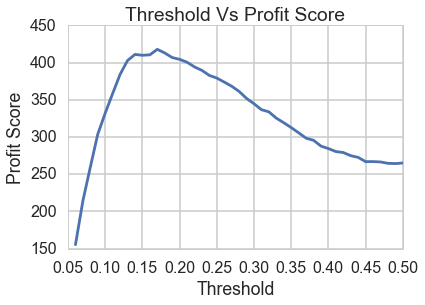

In [66]:
plt.plot(x_axis,y_axis)
plt.xlabel('Threshold')
plt.ylabel('Profit Score')
plt.title('Threshold Vs Profit Score')

In [1]:

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

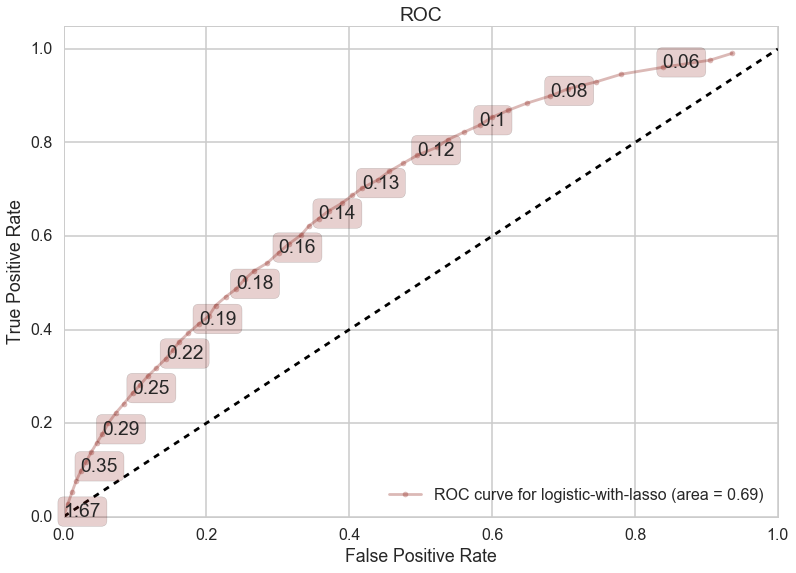

In [141]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)

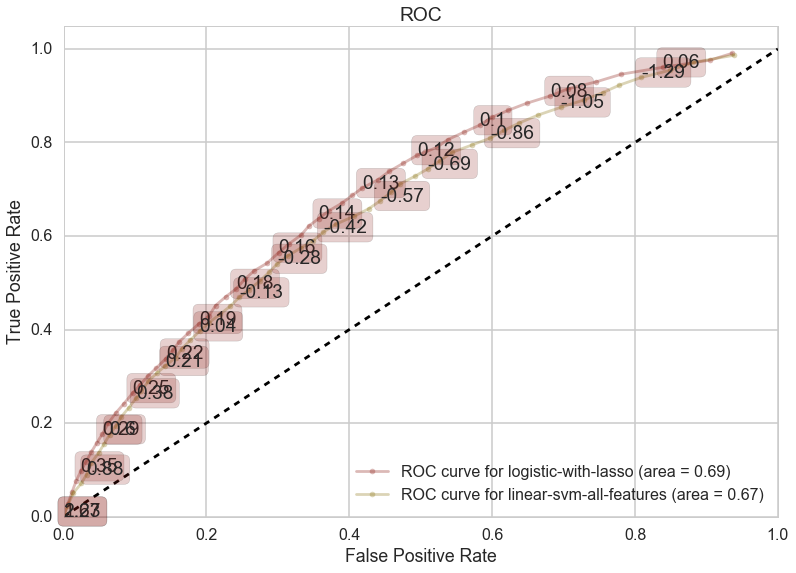

In [142]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)

#### Feature Selection

#### Non Zero Lasso Features

In [70]:
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=predictor_columns, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort_values(by='abscoef', ascending=False)

In [71]:
lasso_importances=nonzero_lasso(logL_best_estimator)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

abscoef      coef
feature                                     
term_ 36 months           0.635809 -0.635809
purpose_small_business    0.596782  0.596782
purpose_car               0.571991 -0.571991
purpose_credit_card       0.511418 -0.511418
purpose_wedding           0.456847 -0.456847
has_record_hist           0.418733  0.418733
grade_G                   0.398054 -0.398054
int_rate                  0.372742  0.372742
purpose_major_purchase    0.346754 -0.346754
purpose_home_improvement  0.324119 -0.324119

#### Features importance using correlation

In [72]:
from scipy.stats.stats import pearsonr
correlations=[]
full_df_train=full_df[mask]
for col in predictor_columns:
    r=pearsonr(full_df_train[col], full_df_train['loan_status'])[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort_values(by='abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(25)

abscorr      corr
feature                                             
int_rate                          0.198351  0.198351
term_ 60 months                   0.155018  0.155018
term_ 36 months                   0.155018 -0.155018
grade_A                           0.135874 -0.135874
avg_fico                          0.123891 -0.123891
revol_util                        0.099024  0.099024
grade_E                           0.089753  0.089753
purpose_small_business            0.083326  0.083326
grade_D                           0.081742  0.081742
grade_F                           0.074319  0.074319
inq_last_6mths                    0.071015  0.071015
loan_amnt                         0.053316  0.053316
has_record_hist                   0.045595  0.045595
verification_status_Not Verified  0.045532 -0.045532
purpose_credit_card               0.043673 -0.043673
grade_B                           0.042938 -0.042938
grade_G                           0.042344  0.042344
bankruptcies                      0.041984  0.041984
verification_status_Verified      0.041183  0.041183
dti                               0.039270  0.039270
grade_C                           0.032639  0.032639
purpose_car                       0.029625 -0.029625
purpose_major_purchase            0.026551 -0.026551
home_ownership                    0.025784 -0.025784
purpose_home_improvement          0.022655 -0.022655

#### Pipeline : Feature select, standardize and train

#### Linear SVM with selected features

In [73]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals    

In [74]:
#applying feature select on SVM which does not have built in feature selection
selectorlinearsvm = SelectKBest(k=25, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [75]:
#parameters passed for Linear SVM
classifier_name = 'Linear SVM'
classifier = pipelinearsvm
param_dict = {"svm__C": [0.0001,0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 5
scor_func = average_profit_func

In [76]:
#calling classifier on training set
pipelsvm_training_time,pipelsvm_best_estimator,pipelsvm_best_params,pipelsvm_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=mask,reuse_split=None)

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


-------------- based on standard predict -----------------
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[10087     0]
 [ 1704     0]]
-----------------------------------------------------------
Linear SVM Training Time : 0.8783538666666673 minutes
Linear SVM Best Estimator 
 Pipeline(steps=[('select', SelectKBest(k=25, score_func=<function pearson_scorer at 0x127ae0488>)), ('svm', LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
Linear SVM Best Params 
 {'svm__C': 100.0}
Linear SVM Best accuracy 
 267.01603053435116


In [77]:
np.array(predictor_columns)[pipelsvm_best_estimator.get_params()['select'].get_support()]

array(['home_ownership', 'verification_status_Not Verified',
       'verification_status_Verified', 'has_record_hist', 'loan_amnt',
       'inq_last_6mths', 'avg_fico', 'revol_util', 'dti', 'int_rate',
       'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'term_ 36 months', 'term_ 60 months', 'purpose_car',
       'purpose_credit_card', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_small_business', 'bankruptcies'], 
      dtype='<U35')

In [78]:
#profit 
profit_svml = average_profit_pl(Y_test, pipelsvm_best_estimator.predict(X_test), u)
profit_svml

257.64896955304891

In [79]:
fpr_svml, tpr_svml, thresholds_svml = roc_curve(Y_test, pipelsvm_best_estimator.decision_function(X_test))
auc_svml = auc(fpr_svml,tpr_svml)
auc_svml

0.50082026975640559

In [80]:
svml_cm = confusion_matrix(Y_test, pipelsvm_best_estimator.predict(X_test))
svml_cm

array([[10087,     0],
       [ 1704,     0]])

In [81]:
svml_sen = round(svml_cm[(1,1)]/(svml_cm[(1,0)] + svml_cm[(1,1)]),2)
svml_sen

0.0

In [82]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_svml,'AUC': round(auc_svml,2),'Sensitivity':svml_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

classifier  Profit Score   AUC  \
0    Base Classifier:Predicting all loans = good    257.648970   NaN   
1                 Logistic Regression with Lasso    265.051480  0.69   
2  Logistic with Lasso modified Threshold = 0.16    410.454414   NaN   
3                                     Linear SVM    257.648970  0.50   

   Sensitivity  
0         0.00  
1         0.01  
2         0.55  
3         0.00

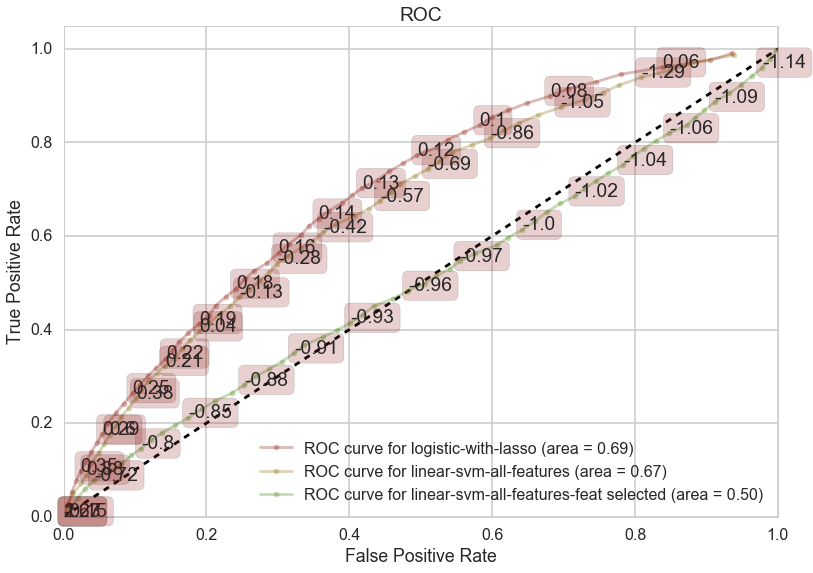

In [143]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-feat selected",pipelsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)

#### Balancing the dataset

In [84]:
jtrain=np.arange(0, Y_train.shape[0])
n_pos=len(jtrain[Y_train.values==1])
n_neg=len(jtrain[Y_train.values==0])
print(n_pos, n_neg)

3948 23562


In [85]:
jtrain[Y_train.values==0]

array([    0,     1,     2, ..., 27506, 27508, 27509])

In [86]:
ineg = np.random.choice(jtrain[Y_train.values==0], n_pos, replace=False)
ineg

array([ 7421, 13522,  4520, ..., 27056, 24911,  2142])

In [87]:
alli=np.concatenate((jtrain[Y_train.values==1], ineg))
alli.shape

(7896,)

In [88]:
alli

array([   13,    14,    16, ..., 27056, 24911,  2142])

In [89]:
X_train_new = X_train.iloc[alli,:]
Y_train_new = Y_train.iloc[alli]
X_train_new.shape, Y_train_new.shape

((7896, 44), (7896,))

In [90]:
reuse_split_new=dict(X_train=X_train_new, X_test=X_test, Y_train=Y_train_new, Y_test=Y_test)

#### Linear SVM with balanced set

In [91]:
#parameters passed for Linear SVM
classifier_name = 'Linear SVM - Balanced'
classifier = LinearSVC(loss="hinge")
param_dict = {"C": [0.00001,0.0001,0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 3
scor_func = average_profit_func

In [92]:
#calling classifier on training set
bal_lsvm_training_time,bal_lsvm_best_estimator,bal_lsvm_best_params,bal_lsvm_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None,reuse_split=reuse_split_new)

using reuse split
-------------- based on standard predict -----------------
Accuracy on training data: 0.61
Accuracy on test data:     0.58
[[5758 4329]
 [ 573 1131]]
-----------------------------------------------------------
Linear SVM - Balanced Training Time : 0.23976131666666636 minutes
Linear SVM - Balanced Best Estimator 
 LinearSVC(C=1e-05, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
Linear SVM - Balanced Best Params 
 {'C': 1e-05}
Linear SVM - Balanced Best accuracy 
 -779.4090678824722


In [93]:
#profit 
profit_svmlb = average_profit_pl(Y_test, bal_lsvm_best_estimator.predict(X_test), u)
profit_svmlb

354.12857264014929

In [94]:
fpr_svmlb, tpr_svmlb, thresholds_svmlb = roc_curve(Y_test, bal_lsvm_best_estimator.decision_function(X_test))
auc_svmlb = auc(fpr_svmlb,tpr_svmlb)
auc_svmlb

0.67497699591022897

In [95]:
svmlb_cm = confusion_matrix(Y_test, bal_lsvm_best_estimator.predict(X_test))
svmlb_cm

array([[5758, 4329],
       [ 573, 1131]])

In [96]:
svmlb_sen = round(svmlb_cm[(1,1)]/(svmlb_cm[(1,0)] + svmlb_cm[(1,1)]),2)
svmlb_sen

0.66000000000000003

In [97]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_svmlb,'AUC': round(auc_svmlb,2),'Sensitivity':svmlb_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

classifier  Profit Score   AUC  \
0    Base Classifier:Predicting all loans = good    257.648970   NaN   
1                 Logistic Regression with Lasso    265.051480  0.69   
2  Logistic with Lasso modified Threshold = 0.16    410.454414   NaN   
3                                     Linear SVM    257.648970  0.50   
4                          Linear SVM - Balanced    354.128573  0.67   

   Sensitivity  
0         0.00  
1         0.01  
2         0.55  
3         0.00  
4         0.66

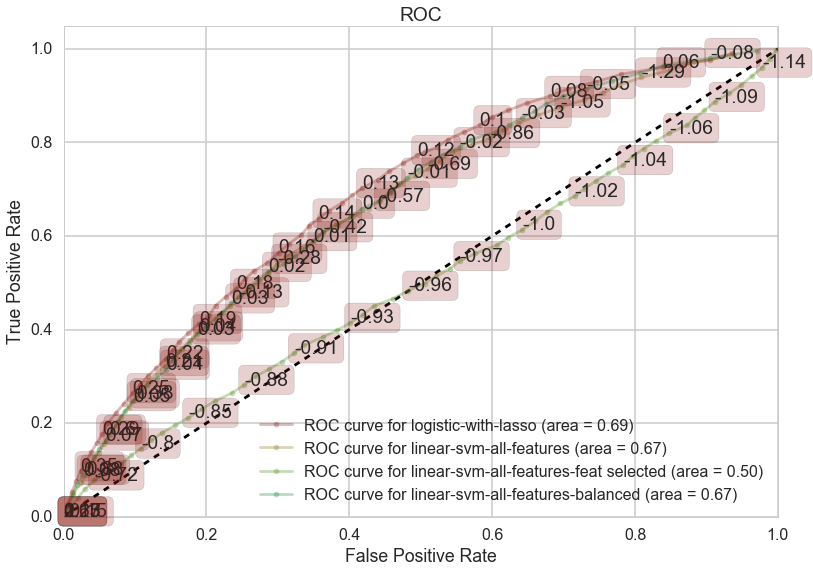

In [144]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-feat selected",pipelsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-balanced",bal_lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)

#### Logistic with balanced

In [99]:
#parameters passed for Linear SVM
classifier_name = 'Logistic Regression with Lasso - balanced'
classifier = LogisticRegression(penalty="l1")
param_dict = {"C": [0.0001,0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 5
scor_func = average_profit_func

In [100]:
#calling classifier on training set
bal_log_training_time,bal_log_best_estimator,bal_log_best_params,bal_log_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None,reuse_split=reuse_split_new)

using reuse split
-------------- based on standard predict -----------------
Accuracy on training data: 0.64
Accuracy on test data:     0.65
[[6545 3542]
 [ 630 1074]]
-----------------------------------------------------------
Logistic Regression with Lasso - balanced Training Time : 0.40903498333333344 minutes
Logistic Regression with Lasso - balanced Best Estimator 
 LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression with Lasso - balanced Best Params 
 {'C': 10.0}
Logistic Regression with Lasso - balanced Best accuracy 
 -798.269883485309


In [101]:
#profit 
profit_logb = average_profit_pl(Y_test, bal_log_best_estimator.predict(X_test), u)
profit_logb

413.57348825375288

In [102]:
fpr_loglb, tpr_loglb, thresholds_loglb = roc_curve(Y_test, bal_log_best_estimator.predict_proba(X_test)[:,1])
auc_loglb = auc(fpr_loglb,tpr_loglb)
auc_loglb

0.69318426171183933

In [103]:
logb_cm = confusion_matrix(Y_test, bal_log_best_estimator.predict(X_test))
logb_cm

array([[6545, 3542],
       [ 630, 1074]])

In [104]:
loglb_sen = round(logb_cm[(1,1)]/(logb_cm[(1,0)] + logb_cm[(1,1)]),2)
loglb_sen

0.63

In [105]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_logb,'AUC': round(auc_loglb,2),'Sensitivity':loglb_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

classifier  Profit Score   AUC  \
0    Base Classifier:Predicting all loans = good    257.648970   NaN   
1                 Logistic Regression with Lasso    265.051480  0.69   
2  Logistic with Lasso modified Threshold = 0.16    410.454414   NaN   
3                                     Linear SVM    257.648970  0.50   
4                          Linear SVM - Balanced    354.128573  0.67   
5      Logistic Regression with Lasso - balanced    413.573488  0.69   

   Sensitivity  
0         0.00  
1         0.01  
2         0.55  
3         0.00  
4         0.66  
5         0.63

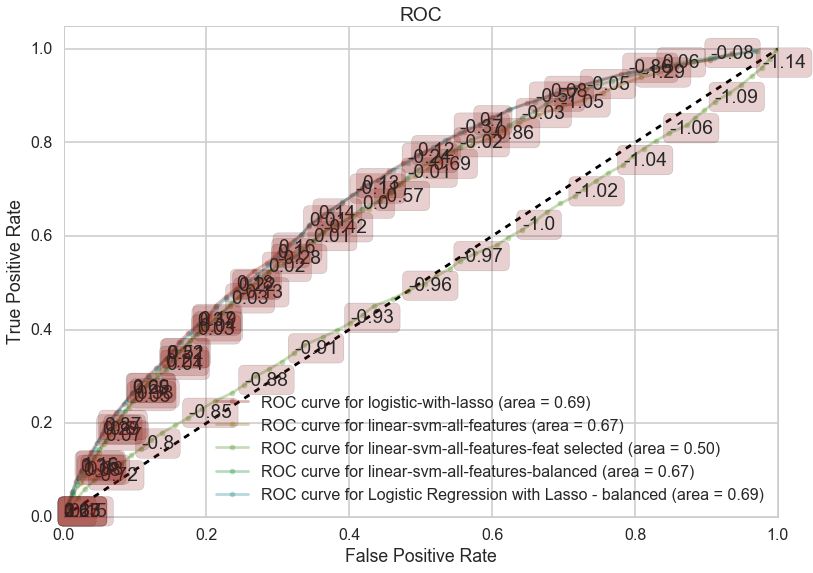

In [145]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-feat selected",pipelsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-balanced",bal_lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("Logistic Regression with Lasso - balanced",bal_log_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)

#### Decision Tree

In [107]:
#parameters passed for Logistic Regression
classifier_name = 'Decision Tree'
classifier = tree.DecisionTreeClassifier()
param_dict = {"criterion": ['gini','entropy'],
              'min_samples_split':[50,100],
              'splitter':['best','random']
             }
no_cv = 3
scor_func = average_profit_func

In [108]:
#calling classifier on training set
bal_dt_training_time,bal_dt_best_estimator,bal_dt_best_params,bal_dt_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None,reuse_split=reuse_split_new)

using reuse split
-------------- based on standard predict -----------------
Accuracy on training data: 0.69
Accuracy on test data:     0.60
[[6001 4086]
 [ 669 1035]]
-----------------------------------------------------------
Decision Tree Training Time : 0.030489500000000665 minutes
Decision Tree Best Estimator 
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')
Decision Tree Best Params 
 {'criterion': 'entropy', 'min_samples_split': 100, 'splitter': 'random'}
Decision Tree Best accuracy 
 -1027.350430597771


In [109]:
#profit 
average_profit_pl(Y_test, bal_dt_best_estimator.predict(X_test), u)

331.87015520312104

#### Random Forest

In [110]:
#parameters passed for Logistic Regression
classifier_name = 'Random Forests'
classifier = RandomForestClassifier()
param_dict = {"criterion": ['gini','entropy'],'min_samples_split':[30,50,100],"n_estimators": [5,10,20,25,50,100]}
no_cv = 3
scor_func = average_profit_func

In [111]:
#calling classifier on training set
bal_rf_training_time,bal_rf_best_estimator,bal_rf_best_params,bal_rf_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None,reuse_split=reuse_split_new)

using reuse split
-------------- based on standard predict -----------------
Accuracy on training data: 0.69
Accuracy on test data:     0.62
[[6207 3880]
 [ 646 1058]]
-----------------------------------------------------------
Random Forests Training Time : 0.6537491999999996 minutes
Random Forests Best Estimator 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Random Forests Best Params 
 {'criterion': 'gini', 'min_samples_split': 100, 'n_estimators': 5}
Random Forests Best accuracy 
 -1026.5593971631206


In [112]:
#profit 
profit_rf = average_profit_pl(Y_test, bal_rf_best_estimator.predict(X_test), u)
profit_rf

367.07344584852854

In [113]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, bal_rf_best_estimator.predict_proba(X_test)[:,1])
auc_rf = auc(fpr_rf,tpr_rf)
auc_rf

0.67030964994221631

In [114]:
rf_cm = confusion_matrix(Y_test, bal_rf_best_estimator.predict(X_test))
rf_cm

array([[6207, 3880],
       [ 646, 1058]])

In [115]:
rf_sen = round(rf_cm[(1,1)]/(rf_cm[(1,0)] + rf_cm[(1,1)]),2)
rf_sen

0.62

In [116]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_rf,'AUC': round(auc_rf,2),'Sensitivity':rf_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

classifier  Profit Score   AUC  \
0    Base Classifier:Predicting all loans = good    257.648970   NaN   
1                 Logistic Regression with Lasso    265.051480  0.69   
2  Logistic with Lasso modified Threshold = 0.16    410.454414   NaN   
3                                     Linear SVM    257.648970  0.50   
4                          Linear SVM - Balanced    354.128573  0.67   
5      Logistic Regression with Lasso - balanced    413.573488  0.69   
6                                 Random Forests    367.073446  0.67   

   Sensitivity  
0         0.00  
1         0.01  
2         0.55  
3         0.00  
4         0.66  
5         0.63  
6         0.62

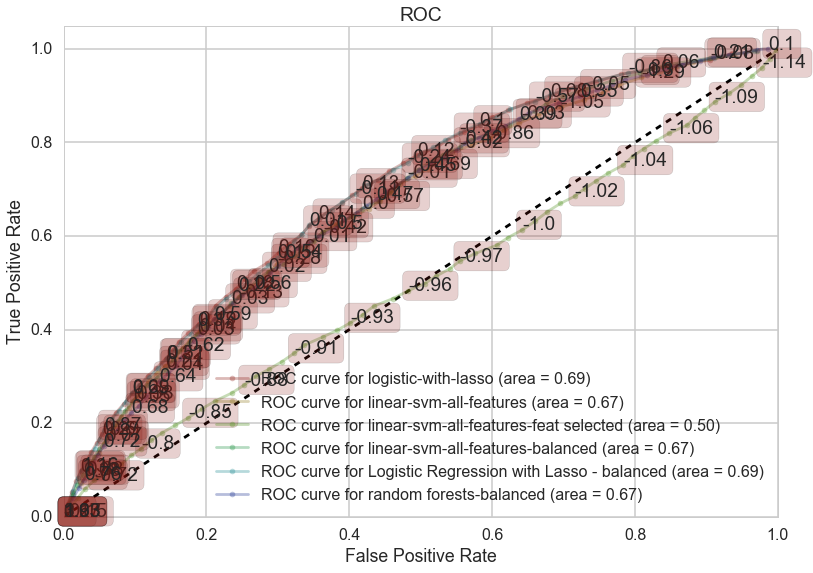

In [146]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-feat selected",pipelsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-balanced",bal_lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("Logistic Regression with Lasso - balanced",bal_log_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("random forests-balanced",bal_rf_best_estimator, Y_test, X_test,ax, labe=200, proba=True, skip=50)

##### Best Classifier trained on the whole set

In [118]:
clf_rf_cvv = RandomForestClassifier(criterion=bal_rf_best_params['criterion'],min_samples_split=bal_rf_best_params['min_samples_split'],n_estimators=bal_rf_best_params['n_estimators'])

In [119]:
#training whole data
clf_rf_cvv.fit(X_train_new, Y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [120]:
y_predict_rf = clf_rf_cvv.predict(X_test)

In [121]:
np.mean(Y_test==y_predict_rf)

0.6186922228818591

In [122]:
confusion_matrix(Y_test,y_predict_rf)

array([[6235, 3852],
       [ 644, 1060]])

In [123]:
#profit 
average_profit_pl(Y_test, clf_rf_cvv.predict(X_test), u)

371.27495547451446

In [124]:
fpr_rf, tpr_rf, thresholds_rf=roc_curve(Y_test, clf_rf_cvv.predict_proba(X_test)[:,1])

In [125]:
auc(fpr_rf,tpr_rf)

0.66940627107544637

In [126]:
cols = list(X_test.columns)

In [127]:
importances = bal_rf_best_estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in bal_rf_best_estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, cols[f], importances[indices[f]]))

Feature ranking:
1. home_ownership (0.212337)
2. verification_status_Not Verified (0.091271)
3. verification_status_Source Verified (0.061962)
4. verification_status_Verified (0.054220)
5. has_delinquent_hist (0.052518)
6. has_record_hist (0.043818)
7. loan_amnt (0.042248)
8. per_act_open (0.040879)
9. inq_last_6mths (0.038084)
10. avg_fico (0.035958)
11. revol_util (0.035877)
12. revol_bal (0.032484)
13. dti (0.030139)
14. years_since_first_credit (0.025842)
15. int_rate (0.025084)
16. emp_length (0.019957)
17. desc_senti_score (0.018243)
18. zip_median_income (0.016883)
19. zip_pop (0.016804)
20. delinq_2yrs (0.009891)
21. grade_A (0.008635)
22. grade_B (0.006966)
23. grade_C (0.006484)
24. grade_D (0.006269)
25. grade_E (0.006085)
26. grade_F (0.006019)
27. grade_G (0.004868)
28. term_ 36 months (0.004567)
29. term_ 60 months (0.004498)
30. purpose_car (0.004412)
31. purpose_credit_card (0.004371)
32. purpose_debt_consolidation (0.004234)
33. purpose_educational (0.004188)
34. purpo

#### Naive Bayes

In [128]:
#parameters passed for Logistic Regression
classifier_name = 'Naive Bayes'
classifier = GaussianNB()
param_dict = {}
no_cv = 2
scor_func = average_profit_func

In [129]:
#calling classifier on training set
bal_nb_training_time,bal_nb_best_estimator,bal_nb_best_params,bal_nb_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None,reuse_split=reuse_split_new)

using reuse split
-------------- based on standard predict -----------------
Accuracy on training data: 0.62
Accuracy on test data:     0.69
[[7285 2802]
 [ 856  848]]
-----------------------------------------------------------
Naive Bayes Training Time : 0.0020516666666660893 minutes
Naive Bayes Best Estimator 
 GaussianNB(priors=None)
Naive Bayes Best Params 
 {}
Naive Bayes Best accuracy 
 -1135.9468085106382


In [130]:
#profit 
profit_nb = average_profit_pl(Y_test, bal_nb_best_estimator.predict(X_test), u)
profit_nb

380.15918921211096

In [131]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(Y_test, bal_nb_best_estimator.predict_proba(X_test)[:,1])
auc_nb = auc(fpr_nb,tpr_nb)
auc_nb

0.66421371160108933

In [132]:
nb_cm = confusion_matrix(Y_test, bal_nb_best_estimator.predict(X_test))
nb_cm

array([[7285, 2802],
       [ 856,  848]])

In [133]:
nb_sen = round(nb_cm[(1,1)]/(nb_cm[(1,0)] + nb_cm[(1,1)]),2)
nb_sen

0.5

In [134]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_nb,'AUC': round(auc_nb,2),'Sensitivity':nb_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

classifier  Profit Score   AUC  \
0    Base Classifier:Predicting all loans = good    257.648970   NaN   
1                 Logistic Regression with Lasso    265.051480  0.69   
2  Logistic with Lasso modified Threshold = 0.16    410.454414   NaN   
3                                     Linear SVM    257.648970  0.50   
4                          Linear SVM - Balanced    354.128573  0.67   
5      Logistic Regression with Lasso - balanced    413.573488  0.69   
6                                 Random Forests    367.073446  0.67   
7                                    Naive Bayes    380.159189  0.66   

   Sensitivity  
0         0.00  
1         0.01  
2         0.55  
3         0.00  
4         0.66  
5         0.63  
6         0.62  
7         0.50

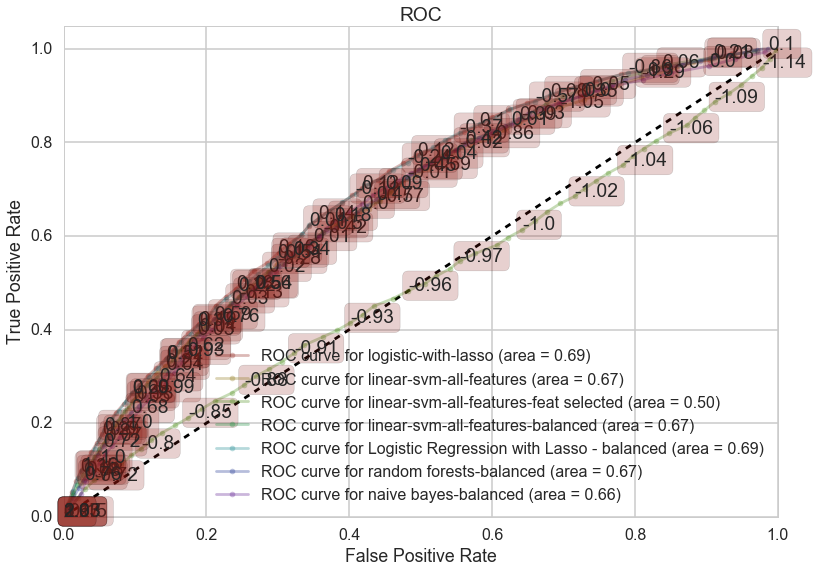

In [147]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-feat selected",pipelsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-balanced",bal_lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("Logistic Regression with Lasso - balanced",bal_log_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("random forests-balanced",bal_rf_best_estimator, Y_test, X_test,ax, labe=200, proba=True, skip=50)
    make_roc("naive bayes-balanced",bal_nb_best_estimator, Y_test, X_test,ax, labe=200, proba=True, skip=50)
    

<a id='result'></a>
### Results

In [136]:
final_scores = pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])
final_scores

classifier  Profit Score   AUC  \
0    Base Classifier:Predicting all loans = good    257.648970   NaN   
1                 Logistic Regression with Lasso    265.051480  0.69   
2  Logistic with Lasso modified Threshold = 0.16    410.454414   NaN   
3                                     Linear SVM    257.648970  0.50   
4                          Linear SVM - Balanced    354.128573  0.67   
5      Logistic Regression with Lasso - balanced    413.573488  0.69   
6                                 Random Forests    367.073446  0.67   
7                                    Naive Bayes    380.159189  0.66   

   Sensitivity  
0         0.00  
1         0.01  
2         0.55  
3         0.00  
4         0.66  
5         0.63  
6         0.62  
7         0.50

In [137]:
#Final ROC eliminating Weak Classifiers

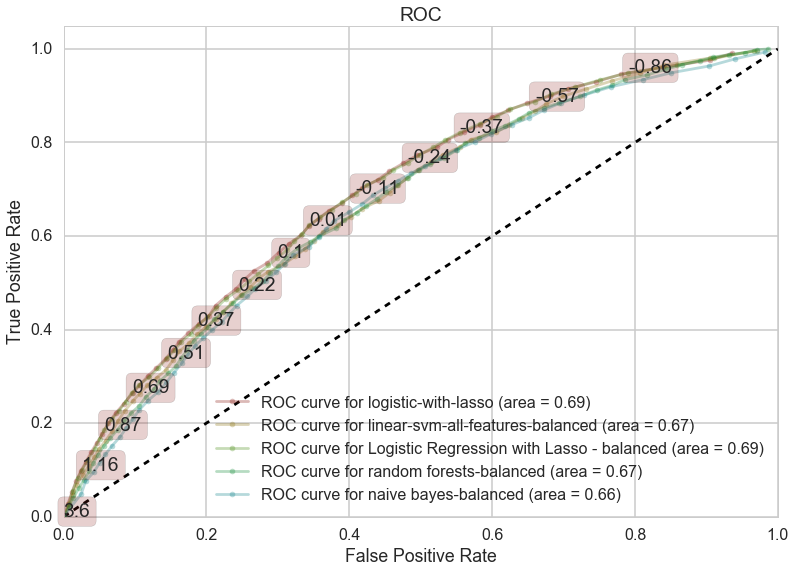

In [148]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=None, skip=50)
    make_roc("linear-svm-all-features-balanced",bal_lsvm_best_estimator, Y_test, X_test,ax, labe=None, proba=False, skip=50)
    make_roc("Logistic Regression with Lasso - balanced",bal_log_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("random forests-balanced",bal_rf_best_estimator, Y_test, X_test,ax, labe=None, proba=True, skip=50)
    make_roc("naive bayes-balanced",bal_nb_best_estimator, Y_test, X_test,ax, labe=None, proba=True, skip=50)
    